In [1]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
plt.rc('text', usetex=True)

from astropy.table import Table

import glob
import os
import pickle

import sys
sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
from functions import illustris_color, tng_color



Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |
      |                  TABLES Version 3.18.3                     |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |


In [147]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle

    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)
        pklFile.close()

        return data
    else:
        warnings.warn("## Can not find %s, return None" % filename)
        return None

def hsc_quantity_in_bin(hsc_gals, mass_bins, quantity, mass_type):
    '''
    returns hsc quantity (e.g. profiles) in given mass bin
    '''
    
    #halo mass bins
    n_bins = len(mass_bins) - 1
    
    profiles_in_bins=[]
    
    if mass_type == 'm_vir':
        masses = hsc_gals['logmh_vir_symbol']
    elif mass_type == 'm_1d_100':
        masses = hsc_gals['logm_100']
    else:
        raise ValueError('mass_type must be "m_vir" or "m_1d_100"')
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        sbps = hsc_gals[quantity][(masses>lower) & (masses<upper)]
        
        sbps = [interp1d(SMA_COMMON, sbp)(hsc_sma) for sbp in sbps]
        
        profiles_in_bins.append(sbps)
        
    return profiles_in_bins


In [149]:

def get_median_profile(isos, pixel_scale, r_bins, quantity = 'intens'):
    """Get the median profiles."""
    
    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
    if quantity == 'intens_kpc':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(r_bins) 
                               for gal in isos]), axis=0)
        
#     elif quantity == 'hsc':
#         mu = np.nanmedian(np.stack([interp1d(SMA_COMMON, 
#                                                gal,
#                                                bounds_error=False, 
#                                                fill_value=np.nan, 
#                                                kind='slinear')(r_bins) 
#                                for gal in isos]), axis=0)


    return mu

In [4]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

#open pickels
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/tng_isos_merged.pkl'

illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_highres.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/illustris_isos_merged.pkl'


tng_masses = open_pkl(tng_masses_file)
tng_isos = open_pkl(tng_isos_file)

illustris_masses = open_pkl(illustris_masses_file)
illustris_isos = open_pkl(illustris_isos_file)


In [150]:
################################################################################
#HSC
# Universal RSMA array
SMA_COMMON = np.arange(0.4, 4.2, 0.01)
hsc_sma = np.arange(0.4, 3.8, 0.05)

#masses
hsc_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)


In [5]:
# TNG_file_highres = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2_highres.hdf5'
# f = h5py.File(TNG_file_highres, 'r')
# map_size = f['config'].attrs['map_range_min']
# n_pixels = f['config'].attrs['map_npixel']
# pixel_scale_highres=2 * (map_size/n_pixels)
# f.close()

# print 'pixel scale: ', pixel_scale_highres
# print map_size, n_pixels

In [7]:
mvir_mass_bins = np.linspace(13.0,14.25,4)
m100_mass_bins = np.linspace(11.4,12.0,4)

In [181]:
def make_three_bin_profile_plot(sim_name, mass_type):
    
    if sim_name == 'TNG':
        sim_color = tng_color
        isos = tng_isos
        masses = tng_masses[mass_type]
        n_gals = 235
        lighter_color = '#78add2'
         
    elif sim_name == 'Illustris':
        sim_color = illustris_color
        isos = illustris_isos
        masses = illustris_masses[mass_type]
        n_gals = 339
        lighter_color = '#e67d7e'
    else:
        raise ValueError('sim_name can only be Illustris or TNG')
        
    assert len(isos) == len(masses) == n_gals
    #mass type
    if mass_type == 'm_1d_100':
        mass_label = 'M_{100}'
        mass_bins = m100_mass_bins
    elif mass_type == 'm_vir':
        mass_label = 'M_{vir}'
        mass_bins = mvir_mass_bins
    else:
        raise ValueError('mass_type must be "m_1d_100" or "m_vir" ')
            
    #mass range1
    isos1=[]
    ngals1=0

    #mass range2
    isos2=[]
    ngals2=0

    #mass range3
    isos3=[]
    ngals3=0

    # create figure
    fig = plt.figure(figsize=(10*6, 12))
    gs1 = gridspec.GridSpec(2, 3, height_ratios=[4,1])
    gs1.update(left=0.05, right=0.48, wspace=0.0, hspace=0.0)
    ax1 = plt.subplot(gs1[0, 0])
    ax2 = plt.subplot(gs1[0, 1])
    ax3 = plt.subplot(gs1[0, 2])
    #residual plots
    ax1res = plt.subplot(gs1[1, 0])
    ax2res = plt.subplot(gs1[1, 1])
    ax3res = plt.subplot(gs1[1, 2])


    ######################################################################################################################
    # plot
    ######################################################################################################################
    #HSC
    hsc_profiles = hsc_quantity_in_bin(hsc_table, mass_bins, quantity='sbp', mass_type=mass_type)
    
    #making a radial cut to only show profiles out to ~200kpc because it flattens out unphysically beyond that
#     hsc_r_bins = hsc_sma[:-40]
#     hsc_r_bins, hsc_median1 = get_median_profile(hsc_profiles[0], 1, quantity = 'hsc')
#     hsc_r_bins, hsc_median2 = get_median_profile(hsc_profiles[1], 1, quantity = 'hsc')
#     hsc_r_bins, hsc_median3 = get_median_profile(hsc_profiles[2], 1, quantity = 'hsc')

    hsc_r_bins = hsc_sma
    #medians
    hsc_median1 = np.nanmedian(hsc_profiles[0], axis=0)
    hsc_median2 = np.nanmedian(hsc_profiles[1], axis=0)
    hsc_median3 = np.nanmedian(hsc_profiles[2], axis=0)

    #stds (masked_invalid to exclude infinities)
    hsc_std1 = np.nanstd(np.ma.masked_invalid(hsc_profiles[0]),axis=0)
    hsc_std2 = np.nanstd(np.ma.masked_invalid(hsc_profiles[1]),axis=0)
    hsc_std3 = np.nanstd(np.ma.masked_invalid(hsc_profiles[2]),axis=0)

    ax1.plot(hsc_r_bins, hsc_median1, linestyle='-', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
    ax2.plot(hsc_r_bins, hsc_median2, linestyle='-', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
    ax3.plot(hsc_r_bins, hsc_median3, linestyle='-', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
    ax1res.plot(hsc_r_bins, np.zeros(len(hsc_r_bins)), linestyle='-', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
    ax2res.plot(hsc_r_bins, np.zeros(len(hsc_r_bins)), linestyle='-', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')
    ax3res.plot(hsc_r_bins, np.zeros(len(hsc_r_bins)), linestyle='-', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC')

    ax1.fill_between(hsc_r_bins, hsc_median1+hsc_std1, hsc_median1-hsc_std1, 
                     alpha=0.4, color='k', zorder=1, linewidth=3)
    ax2.fill_between(hsc_r_bins, hsc_median2+hsc_std2, hsc_median2-hsc_std2, 
                     alpha=0.4, color='k', zorder=1, linewidth=3)
    ax3.fill_between(hsc_r_bins, hsc_median3+hsc_std3, hsc_median3-hsc_std3, 
                     alpha=0.4, color='k', zorder=1, linewidth=3)
    ax1res.fill_between(hsc_r_bins, hsc_std1, -hsc_std1, 
                     alpha=0.4, color='k', zorder=1, linewidth=3)
    ax2res.fill_between(hsc_r_bins, hsc_std2, -hsc_std2, 
                     alpha=0.4, color='k', zorder=1, linewidth=3)
    ax3res.fill_between(hsc_r_bins, hsc_std3, -hsc_std3, 
                     alpha=0.4, color='k', zorder=1, linewidth=3)
    ############################################################################################################
    ##TNG
    for mass, iso in zip(masses, isos):
        
        #get rid of low or high masses or mergers with weird profile
        if (mass<mass_bins[0]) or (mass>mass_bins[3]) or \
        np.log10(interp1d(iso['sma_kpc'], iso['intens_kpc'])(5))<8.0:
            continue
        elif (mass>=mass_bins[0]) and (mass<mass_bins[1]):
            ngals1+=1

            isos1.append(iso)

            ax1.plot(hsc_sma, 
                     np.log10(interp1d(iso['sma_kpc'], iso['intens_kpc'])(hsc_sma**4))+ np.log10(0.7 ** 2.0),
                     linewidth=2, c=lighter_color, alpha=0.7, 
                     label='_nolegend_', linestyle = ':')

        elif (mass>=mass_bins[1]) and (mass<mass_bins[2]):
            ngals2+=1

            isos2.append(iso)

            ax2.plot(hsc_sma, 
                     np.log10(interp1d(iso['sma_kpc'], iso['intens_kpc'])(hsc_sma**4))+ np.log10(0.7 ** 2.0),
                     linewidth=2, c=lighter_color, alpha=0.7, 
                     label='_nolegend_', linestyle = ':')

        elif (mass>=mass_bins[2]) and (mass<mass_bins[3]):
            ngals3+=1

            isos3.append(iso)

            ax3.plot(hsc_sma, 
                     np.log10(interp1d(iso['sma_kpc'], iso['intens_kpc'])(hsc_sma**4))+ np.log10(0.7 ** 2.0),
                     linewidth=2, c=lighter_color, alpha=0.7, 
                     label='_nolegend_', linestyle = ':')

    ## median profiles for tng
    median_mu1 = get_median_profile(isos1, pixel_scale = 0, r_bins = hsc_r_bins, quantity = 'intens_kpc')
    median_mu2 = get_median_profile(isos2, pixel_scale = 0, r_bins = hsc_r_bins, quantity = 'intens_kpc')
    median_mu3 = get_median_profile(isos3, pixel_scale = 0, r_bins = hsc_r_bins, quantity = 'intens_kpc')

    
    ax1.plot(hsc_r_bins, median_mu1+ np.log10(0.7 ** 2.0), linewidth=7.0, c=sim_color, alpha=1,
             label=sim_name, zorder=5)
    ax2.plot(hsc_r_bins, median_mu2+ np.log10(0.7 ** 2.0), linewidth=7.0, c=sim_color, alpha=1,
             label=sim_name, zorder=5)
    ax3.plot(hsc_r_bins, median_mu3+ np.log10(0.7 ** 2.0), linewidth=7.0, c=sim_color, alpha=1,
             label=sim_name, zorder=5)

    ax1res.plot(hsc_r_bins, median_mu1+ np.log10(0.7 ** 2.0)-hsc_median1, linewidth=7.0, c=sim_color,
                alpha=1, label=sim_name, zorder=5)
    ax2res.plot(hsc_r_bins, median_mu2+ np.log10(0.7 ** 2.0)-hsc_median2, linewidth=7.0, c=sim_color,
                alpha=1, label=sim_name, zorder=5)
    ax3res.plot(hsc_r_bins, median_mu3+ np.log10(0.7 ** 2.0)-hsc_median3, linewidth=7.0, c=sim_color,
                alpha=1, label=sim_name, zorder=5)

    print ngals1, ngals2, ngals3


    ######################################################################################################################
    # plot details
    ######################################################################################################################
    # # X-Y limits
    ax1.set_xlim(0.9, 3.9)
    ax1.set_ylim(4.1, 10)
    ax2.set_xlim(0.9, 3.9)
    ax2.set_ylim(4.1, 10)
    ax3.set_xlim(0.9, 3.9)
    ax3.set_ylim(4.1, 10)
    ax1res.set_ylim(-0.8, 0.8)
    ax2res.set_ylim(-0.8, 0.8)
    ax3res.set_ylim(-0.8, 0.8)

    ax1.tick_params(axis='y', which='major', labelsize=35)
    ax1res.tick_params(axis='y', which='major', labelsize=35)
    ax1res.tick_params(axis='x', which='major', labelsize=35)
    ax2res.tick_params(axis='x', which='major', labelsize=35)
    ax3res.tick_params(axis='x', which='major', labelsize=35)
        
    ax1.text(1.65, 4.2, r'${0}<{1}<{2}$'.format(round(mass_bins[0],2),mass_label, round(mass_bins[1],2)),
             size=32)
    ax2.text(1.65, 4.2, r'${0}<{1}<{2}$'.format(round(mass_bins[1],2),mass_label, round(mass_bins[2],2)),
             size=32)
    ax3.text(1.65, 4.2, r'${0}<{1}<{2}$'.format(round(mass_bins[2],2),mass_label, round(mass_bins[3],2)),
             size=32)

    ax1.legend(loc= 'upper center', fontsize=35)

    #add twin x axis in kpc
    x1, x2 = ax1.get_xlim()
    ax1_twin = ax1.twiny()
    ax1_twin.set_xlim(x1, x2)
    ax1_twin.figure.canvas.draw()
    ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
    ax1_twin.xaxis.set_ticklabels([r'$2$', r'$5$', r'$10$', r'$50$', r'$100$', r'$200$'])
    ax1_twin.tick_params(axis='both', which='major', labelsize=35)
    ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=40)
    ax1res.set_xlim(x1, x2)

    x1, x2 = ax2.get_xlim()
    ax2_twin = ax2.twiny()
    ax2_twin.set_xlim(x1, x2)
    ax2_twin.figure.canvas.draw()
    ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
    ax2_twin.xaxis.set_ticklabels([r'$2$', r'$5$', r'$10$', r'$50$', r'$100$', r'$200$'])
    ax2_twin.tick_params(axis='both', which='major', labelsize=35)
    ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=40)
    ax2res.set_xlim(x1, x2)

    x1, x2 = ax3.get_xlim()
    ax3_twin = ax3.twiny()
    ax3_twin.set_xlim(x1, x2)
    ax3_twin.figure.canvas.draw()
    ax3_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
    ax3_twin.xaxis.set_ticklabels([r'$2$', r'$5$', r'$10$', r'$50$', r'$100$', r'$200$'])
    ax3_twin.tick_params(axis='both', which='major', labelsize=35)
    ax3_twin.set_xlabel(r'$R \: [kpc]$', fontsize=40)
    ax3res.set_xlim(x1, x2)


    ######################################################################################################################

    #axis labels and vertical lines
    ax1res.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
    ax2res.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
    ax3res.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
    ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot}/\mathrm{kpc}^2)]$', fontsize=40)
    ax1res.set_ylabel(r'$\Delta\mu_{\star}$', fontsize=40)
    
    #vertical lines for HSC limits
    ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax1.axvline(6.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax2.axvline(6.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax3.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax3.axvline(6.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax1res.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax1res.axvline(6.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax2res.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax2res.axvline(6.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax3res.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')
    ax3res.axvline(6.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c='k')

    #grey out psf region
    ax1.axvspan(0, 6**0.25, alpha=0.25, color='grey')
    ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
    ax3.axvspan(0, 6**0.25, alpha=0.25, color='grey')
    ax1res.axvspan(0, 6**0.25, alpha=0.25, color='grey')
    ax2res.axvspan(0, 6**0.25, alpha=0.25, color='grey')
    ax3res.axvspan(0, 6**0.25, alpha=0.25, color='grey')

    
    #add simulation stellar particle softening length: 0.71 (TNG), 0.74 (Illustris)
    # 3 times the softening lenght will be around 2.15 kpc for both
    ax1.axvline(2.15 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c=sim_color)
    ax2.axvline(2.15 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c=sim_color)
    ax3.axvline(2.15 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c=sim_color)
    ax1res.axvline(2.15 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c=sim_color)
    ax2res.axvline(2.15 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c=sim_color)
    ax3res.axvline(2.15 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.5, c=sim_color)    
    ######################################################################################################################
    #adjustments to ticks and space between subplots

    #plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax2res.get_yticklabels(), visible=False)
    plt.setp(ax3res.get_yticklabels(), visible=False)

    #remove last label in x-axis of ax1 to prevent overlaping of labels with ax2
    labels1 = [item.get_text() for item in ax2.get_xticklabels()[:-1]]
    ax1.set_xticklabels(labels1)

    #add a bit of space between subplots
    fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/profiles_matched_by_{0}_{1}.pdf'.format(mass_type, sim_name),
                dpi=100, format='pdf', bbox_inches='tight')

    plt.show()

    
    return

TODO: get HSC and sims at the same radial bins!

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


98 39 13


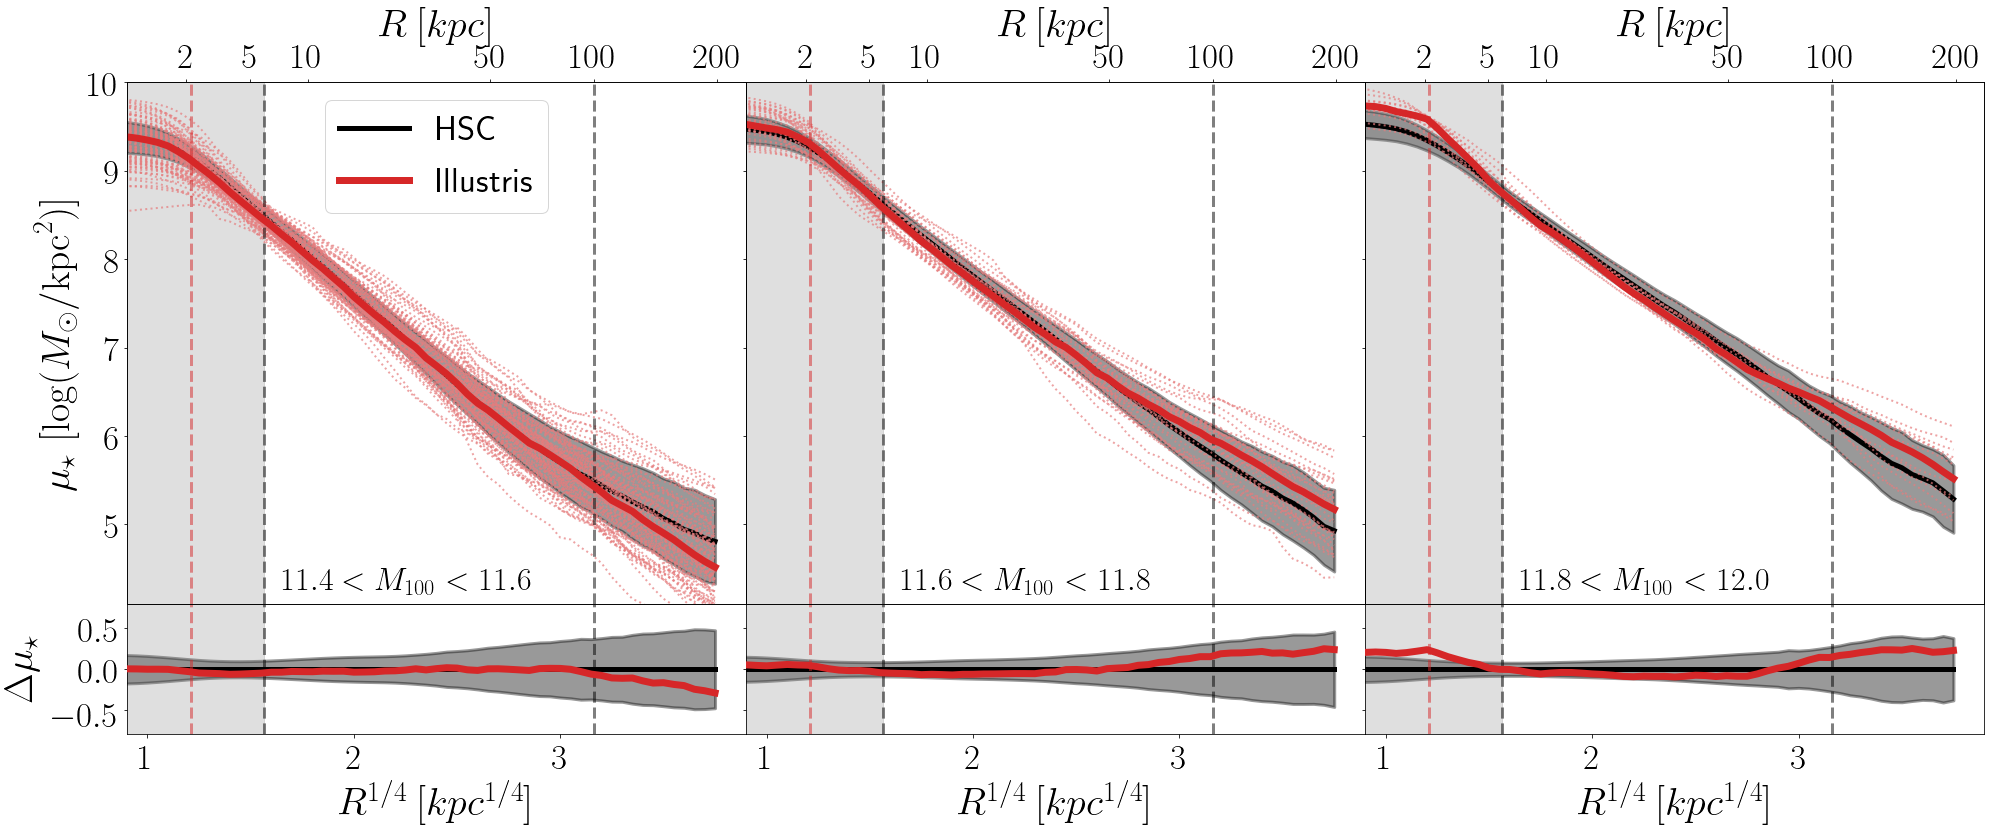

In [182]:
make_three_bin_profile_plot('Illustris', mass_type='m_1d_100')


/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


59 18 12


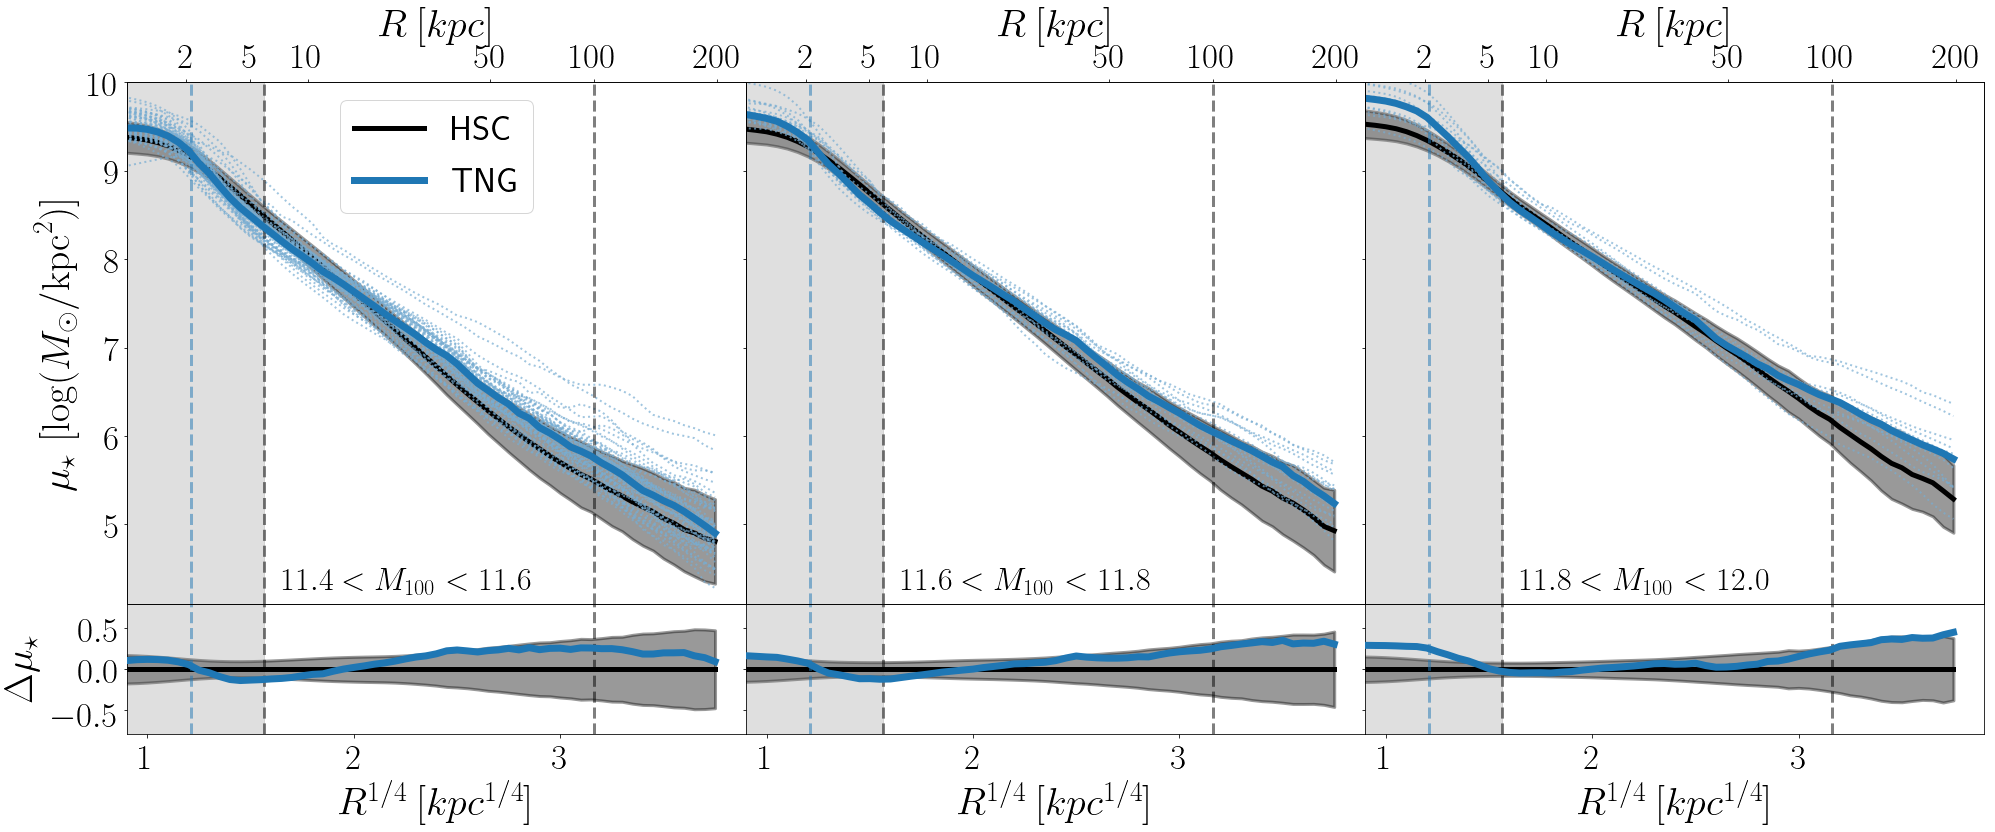

In [183]:
make_three_bin_profile_plot('TNG', mass_type='m_1d_100')

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


62 21 6


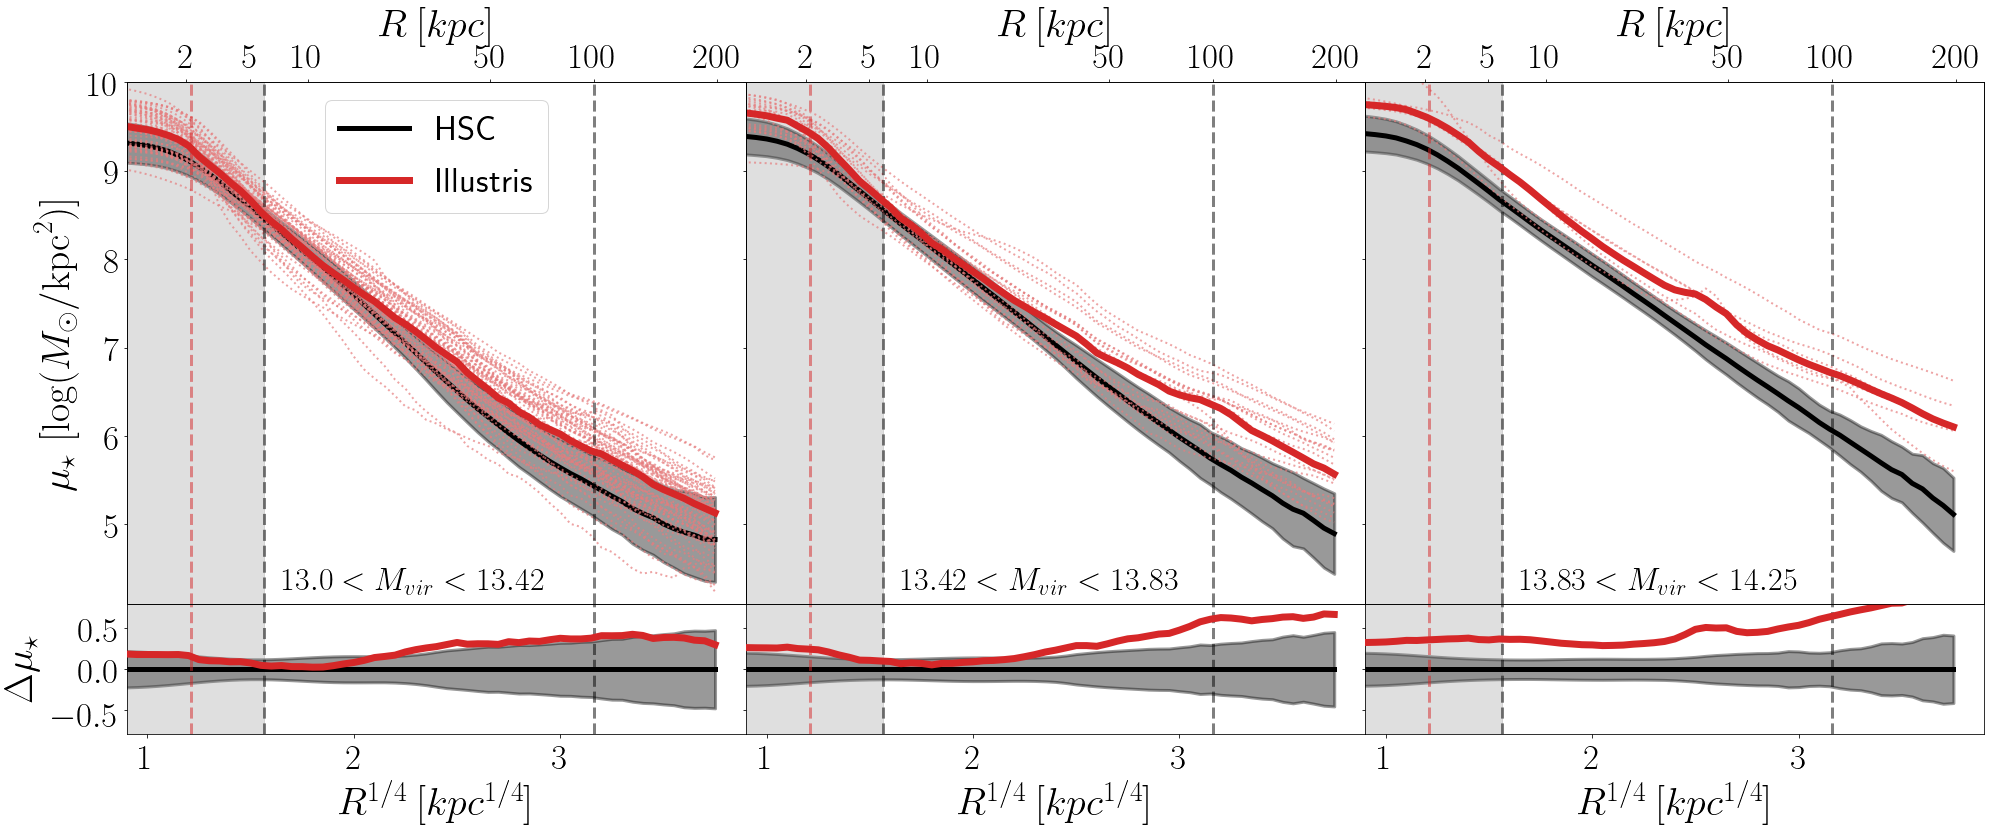

In [184]:
make_three_bin_profile_plot('Illustris', mass_type='m_vir')

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


82 35 13


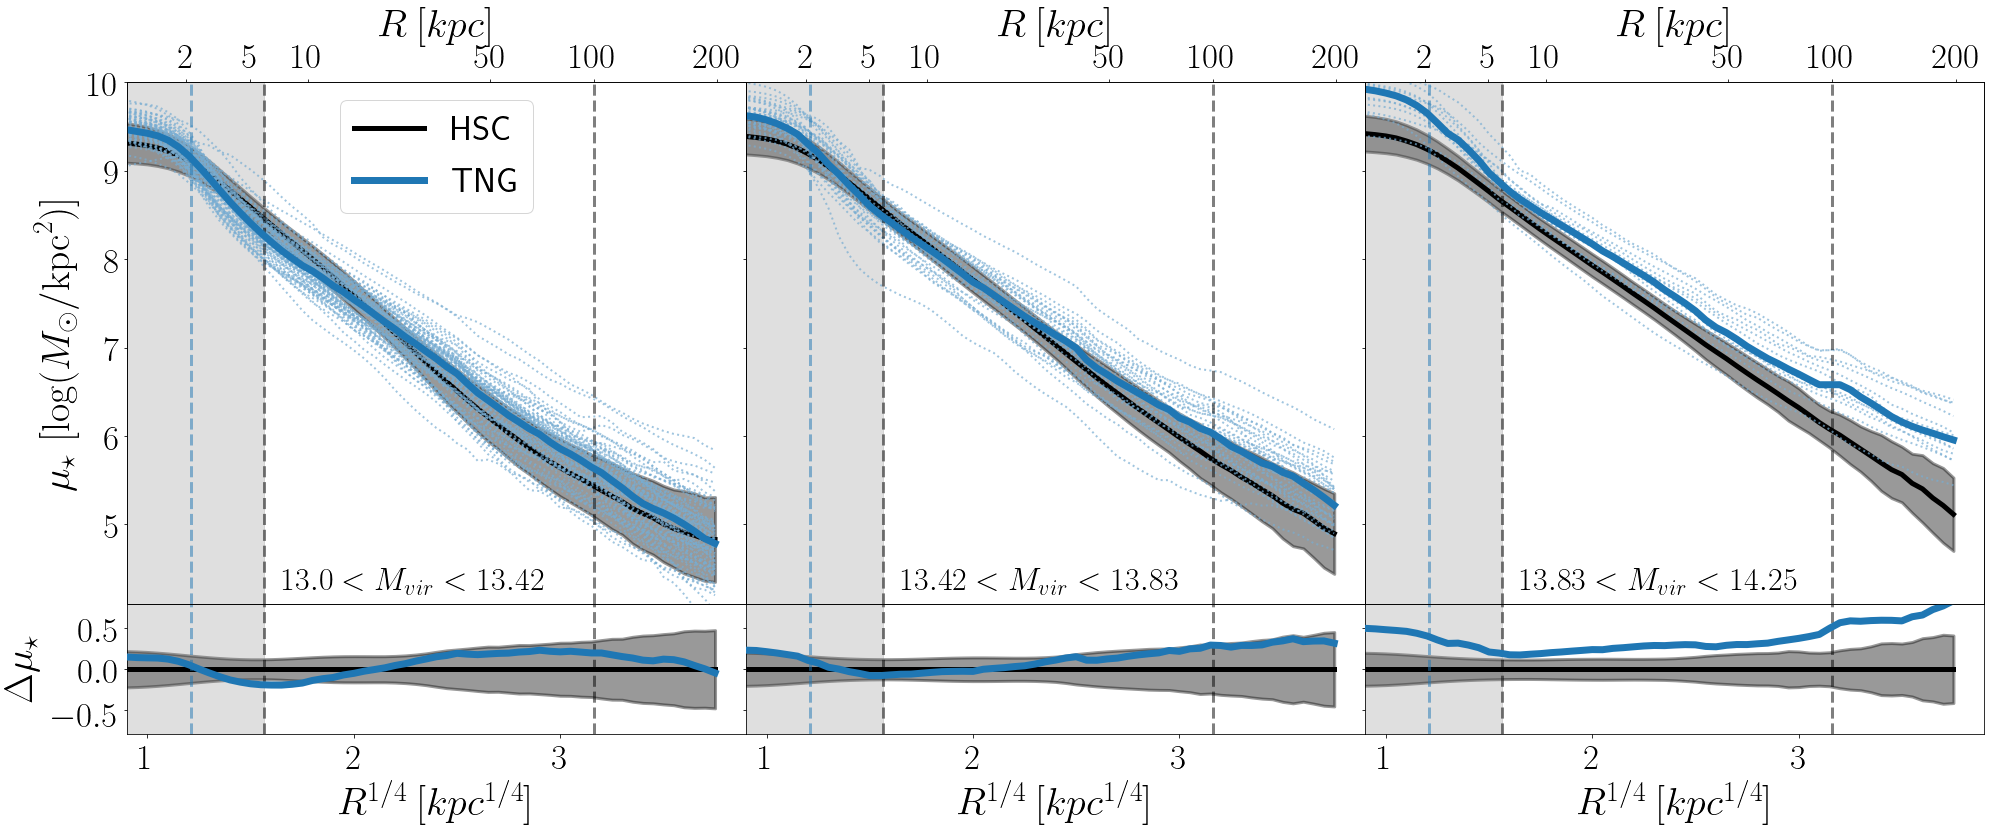

In [185]:
make_three_bin_profile_plot('TNG', mass_type='m_vir')